# ***Importing Libraries***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import zipfile
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from zipfile import ZipFile
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import layers, models
from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
import datetime
from tensorflow.keras.layers import Dropout

In [2]:
from google.colab import drive  #connecting to google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_zip = "/content/drive/MyDrive/data.zip"
folder_extraction = "/content/drive/MyDrive/AgeImageExtractionfolder"

with ZipFile(folder_zip, 'r') as image_files:
    image_files.extractall(folder_extraction)


In [4]:
print(os.listdir(folder_extraction))

['Train', 'train.csv']


In [5]:
class_path = os.path.join(folder_extraction, "train.csv")
extracted_image_folder = os.path.join(folder_extraction, "Train")

In [6]:
nooffiles = len(os.listdir(extracted_image_folder))
print(f"Number of files in '{extracted_image_folder}': {nooffiles}")

Number of files in '/content/drive/MyDrive/AgeImageExtractionfolder/Train': 19906


In [7]:
age_class_csv=pd.read_csv(class_path)
trainfolder_images=[]
labeling_person_age=[]

In [8]:
le=LabelEncoder()
le.fit(age_class_csv['Class'])
age_class_csv['Class']=le.transform(age_class_csv['Class'])

In [9]:
age_class_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 311.2+ KB


In [10]:
age_class_csv.head(20)

,ID,Class
0,377.jpg,0
1,17814.jpg,2
2,21283.jpg,0
3,16496.jpg,2
4,4487.jpg,0
5,6283.jpg,0
6,23495.jpg,2
7,7100.jpg,2
8,6028.jpg,2
9,22617.jpg,1


0- Middle, 2- Young, 1- Old

# ***Appending to a Numpy Array***

In [11]:
#appending to List
for i,j in age_class_csv.iterrows():
  path_of_images=os.path.join(extracted_image_folder,j['ID'])
  filenameof_images=Image.open(path_of_images)
  listofimage=np.array(filenameof_images)
  trainfolder_images.append(listofimage)
  labeling_person_age.append(j['Class'])

In [12]:
picture=np.array(trainfolder_images)
class_labeling=np.array(labeling_person_age)

<ipython-input-12-45743b5f27f5>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  picture=np.array(trainfolder_images)


In [13]:
print(len(picture))
print(len(class_labeling))

19906
19906


In [14]:
print(type(picture))
print(type(class_labeling))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# ***Splitting the Data***

In [15]:
X_train,X_test,y_train,y_test=train_test_split(picture,class_labeling,test_size=0.20)

In [16]:
print(len(X_train))
print(len(X_test))

15924
3982


In [17]:
print(X_train[0].shape)
print(X_train[1].shape)

(53, 49, 3)
(144, 69, 3)


In [18]:
print(y_train[0])
print(y_train[1])

0
0


In [19]:
print(type(y_train[0]))
print(type(y_train[1]))

<class 'numpy.int64'>
<class 'numpy.int64'>


# ***Image Augmentation***

In [20]:
seg_of_image_train=[]

In [21]:
from PIL import Image,ImageOps

In [22]:
for training in X_train:
  image_using_pillow = Image.fromarray(np.uint8(training))
  modified_images = image_using_pillow.resize((64,64), Image.ANTIALIAS) #Resizing the images

  #Data Preprocessing
  angle = random.uniform(-30, 30)
  brightness = random.uniform(0.5,1.5)
  modified_images = modified_images.rotate(angle, resample=Image.BILINEAR) #Rotating randomly between -30 and 30
  modified_images = modified_images.transpose(Image.Transpose.FLIP_LEFT_RIGHT) #Transpose the image by flip it top and bottom
  modified_images = ImageEnhance.Brightness(modified_images).enhance(brightness) #adjusting the brightness
  resized_image_train = img_to_array(modified_images)
  resized_image_train = resized_image_train/255.0  #Rescaling the image pixels
  seg_of_image_train.append(resized_image_train)

<ipython-input-22-40b3f465e37d>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  modified_images = image_using_pillow.resize((64,64), Image.ANTIALIAS) #Resizing the images


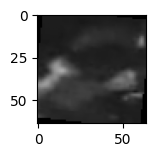

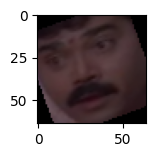

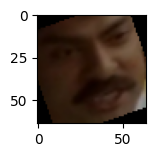

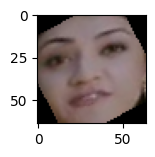

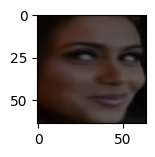

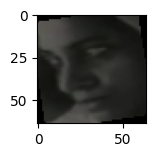

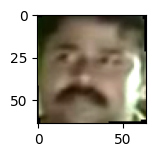

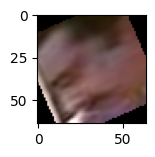

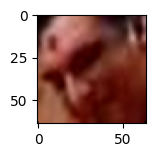

In [23]:
for display_image in range(9):
  plt.subplot(3,3,display_image+1)
  plt.imshow(seg_of_image_train[display_image])
  plt.show()

In [24]:
seg_of_image_train=np.array(seg_of_image_train)

In [25]:
print(len(seg_of_image_train))

15924


In [26]:
print(seg_of_image_train[0].shape)
print(seg_of_image_train[15923].shape)

(64, 64, 3)
(64, 64, 3)


In [27]:
seg_of_image_test=[]

In [28]:
for testing in X_test:
  image_using_pillow_test = Image.fromarray(np.uint8(testing))
  modified_images_test = image_using_pillow_test.resize((64,64), Image.ANTIALIAS) #Resizing
  resized_image_test = img_to_array(modified_images_test)
  resized_image_test = resized_image_test/255.0 #Rescaling
  seg_of_image_test.append(resized_image_test)

<ipython-input-28-fde7c125a71c>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  modified_images_test = image_using_pillow_test.resize((64,64), Image.ANTIALIAS) #Resizing


In [29]:
seg_of_image_test=np.array(seg_of_image_test)

In [30]:
print(len(seg_of_image_test))

3982


In [31]:
print(seg_of_image_test[0].shape)
print(seg_of_image_test[3981].shape)

(64, 64, 3)
(64, 64, 3)


In [32]:
print(y_train[0].shape)

()


In [33]:
print(f"shape of training images : {seg_of_image_train.shape}")
print(f"shape of test images : {seg_of_image_test.shape}")
print(f"shape of training labels : {y_train.shape}")
print(f"shape of test labels : {y_test.shape}")

shape of training images : (15924, 64, 64, 3)
shape of test images : (3982, 64, 64, 3)
shape of training labels : (15924,)
shape of test labels : (3982,)


# ***CNN Model for Calculating Accuracy of the model***

In [34]:
making_prediction_model = models.Sequential([

        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(3, activation='softmax')
    ])


In [35]:
making_prediction_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
making_prediction_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [37]:
logs = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1)

In [38]:
tabulated_values=making_prediction_model.fit(seg_of_image_train, y_train, epochs=20, batch_size=32, validation_data=(seg_of_image_test, y_test),callbacks=[callback])

Epoch 1/20
498/498 [==============================] - 12s 10ms/step - loss: 0.9295 - accuracy: 0.5619 - val_loss: 0.8399 - val_accuracy: 0.6374
Epoch 2/20
498/498 [==============================] - 4s 7ms/step - loss: 0.8163 - accuracy: 0.6403 - val_loss: 0.7675 - val_accuracy: 0.6728
Epoch 3/20
498/498 [==============================] - 4s 8ms/step - loss: 0.7504 - accuracy: 0.6794 - val_loss: 0.7385 - val_accuracy: 0.6956
Epoch 4/20
498/498 [==============================] - 4s 8ms/step - loss: 0.7099 - accuracy: 0.6999 - val_loss: 0.7306 - val_accuracy: 0.6826
Epoch 5/20
498/498 [==============================] - 4s 8ms/step - loss: 0.6698 - accuracy: 0.7182 - val_loss: 0.7130 - val_accuracy: 0.6926
Epoch 6/20
498/498 [==============================] - 4s 8ms/step - loss: 0.6336 - accuracy: 0.7351 - val_loss: 0.7007 - val_accuracy: 0.7092
Epoch 7/20
498/498 [==============================] - 4s 9ms/step - loss: 0.6013 - accuracy: 0.7481 - val_loss: 0.6977 - val_accuracy: 0.7077
Epoc

In [39]:
loss_of_test_data, accuracy_of_test_data = making_prediction_model.evaluate(seg_of_image_test,  y_test, verbose=2)
print(f"Accuracy of data: {accuracy_of_test_data*100}%")

125/125 - 0s - loss: 1.2670 - accuracy: 0.7250 - 375ms/epoch - 3ms/step
Accuracy of data: 72.50125408172607%


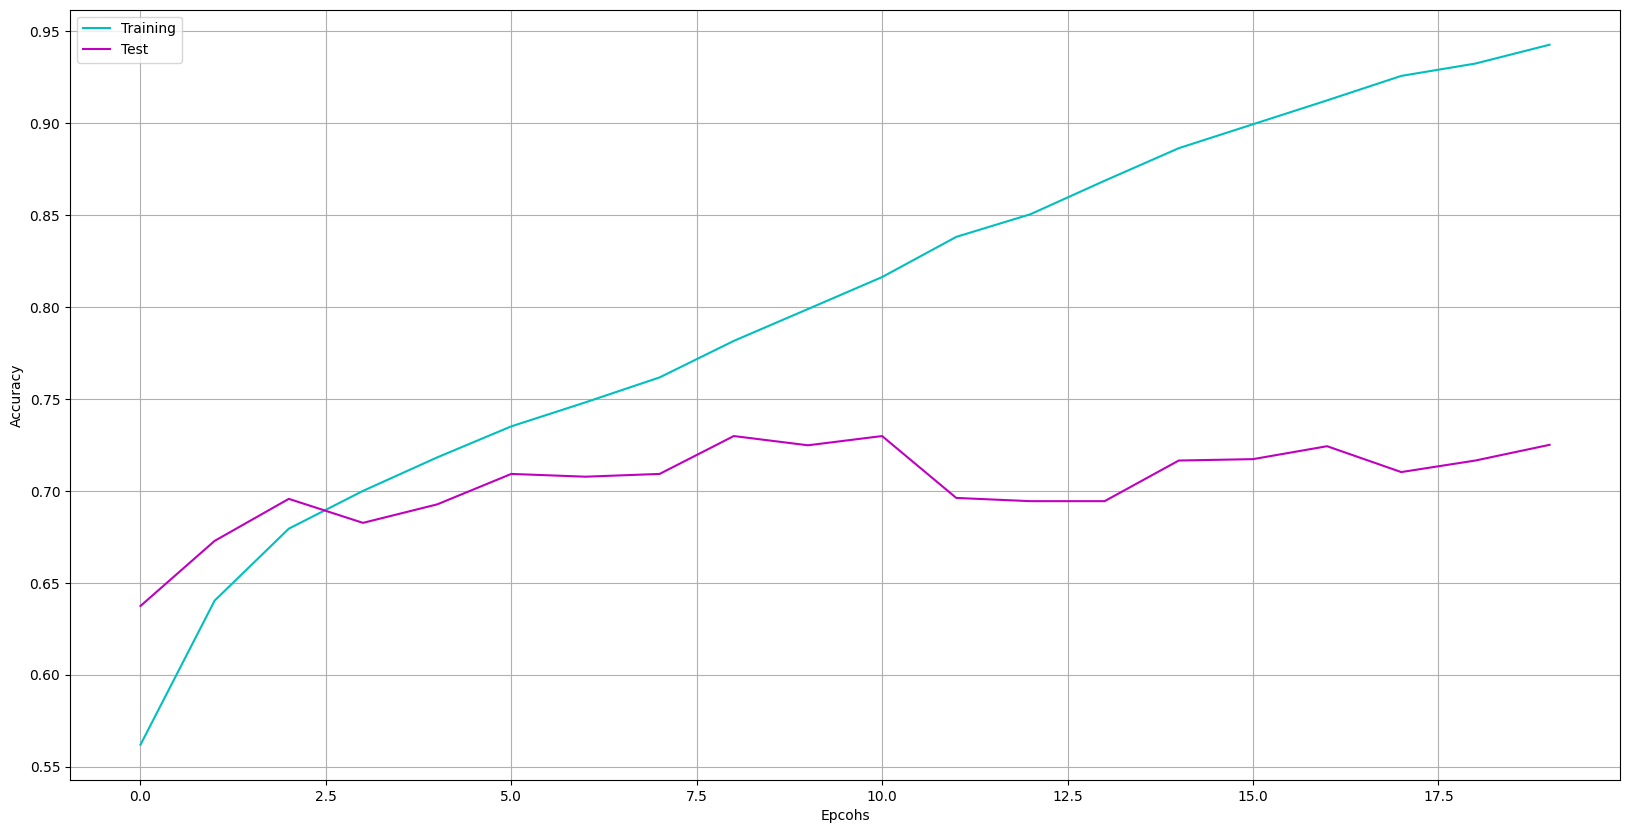

In [40]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.plot(tabulated_values.history['accuracy'],color='c')
plt.plot(tabulated_values.history['val_accuracy'],color='m')
plt.legend(['Training','Test'],loc='upper left')
plt.xlabel('Epcohs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

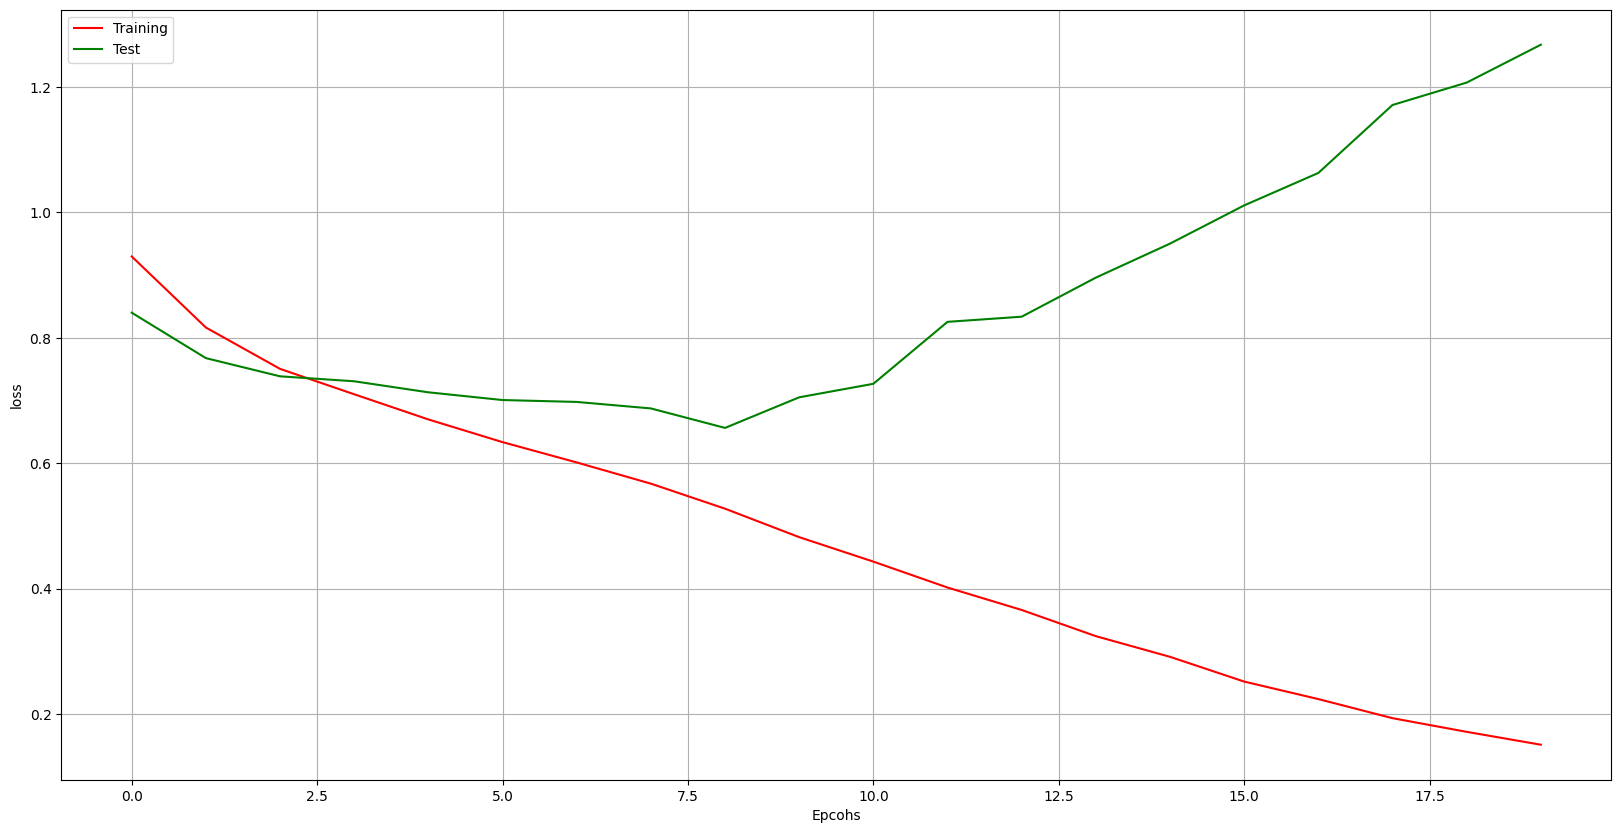

In [41]:
plt.rcParams["figure.figsize"] = [20, 10]
plt.plot(tabulated_values.history['loss'],color='r')
plt.plot(tabulated_values.history['val_loss'],color='g')
plt.legend(['Training','Test'],loc='upper left')
plt.xlabel('Epcohs')
plt.ylabel('loss')
plt.grid()
plt.show()

# ***ANVIL and connecting using uplink to the server***

In [42]:
pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=e6b3c936c68a32b02f1d8729b7eecfe1cc4fa404f3715dcad7bff7495bbcab91
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [43]:
import anvil.server
import anvil.media

In [44]:
anvil.server.connect("server_WBJCMKXBRXDSVYFXVLADA4FG-DQB2NKDUZLR6T2NS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Guess Your Age " as SERVER


In [45]:
@anvil.server.callable
def person_age(file):
  with anvil.media.TempFile(file) as system_file:
    anvil_app_image_load = load_img(system_file)
    anvil_img_resized= anvil_app_image_load.resize((64,64), resample=Image.BICUBIC)
    readable_img = img_to_array(anvil_img_resized)
    readable_img = np.expand_dims(readable_img, axis=0)
    readable_img = readable_img/255
    class_output=making_prediction_model.predict(readable_img)
    class_accommodate_anvil = np.argmax(class_output)
    if class_accommodate_anvil==0:
       return 'Old'
    elif class_accommodate_anvil==1:
       return 'Middle'
    else:
       return 'Young'

In [46]:
#anvil.server.wait_forever()